# Imports

In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

In [2]:
# Computational packages
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler

#import seaborn as sns
import torch
import tqdm
#import cv2 as cv

# General packages
import datetime
import sys
import os

# custom packages
import ratsimulator
from ratsimulator.Environment import Rectangle
import spatial_maps as sm # CINPLA spatial maps

# avoid adding multiple relave paths to sys.path
sys.path.append("../../src") if "../../src" not in sys.path else None 
from PlaceCells import PlaceCells
from Models import SorscherRNN
from Experiment import Experiment
from methods import *
from datahandling import *
from stats import *
from astropy.convolution import Gaussian2DKernel, convolve

#import umap
#import plotly.graph_objects as go
#import plotly.offline as pyo
# Set notebook mode to work in offline
#pyo.init_notebook_mode()

/home/konstantin/anaconda3/envs/emergent-gcs/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [147]:
plt.rcParams.update({'figure.figsize': (10,4), 'figure.dpi': 150, 'legend.frameon': False})
# sns.set_style('white', {'legend.frameon': False})
palette = {0: '#e41a1c', 1: '#377eb8', 2: '#4daf4a'}

alpha = 0.5
import matplotlib.colors
to_rgba = matplotlib.colors.ColorConverter().to_rgba

cols = []
for i, col in enumerate(palette):
    cols.append(to_rgba(palette[col], alpha))
    
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)

def savefig(fname,filetype='svg'):
    plot_path = paths['experiment'] / 'plots'
    if not os.path.exists(plot_path):
        os.makedirs(plot_path)
    plt.savefig(plot_path / f'{fname}.{filetype}', bbox_inches='tight', transparent=True)
    
"""
sns.countplot(data=df, x=df.variety, palette=palette)
plt.xticks(rotation=45)
sns.despine()
plt.xlabel('')
savefig('count')
"""

"\nsns.countplot(data=df, x=df.variety, palette=palette)\nplt.xticks(rotation=45)\nsns.despine()\nplt.xlabel('')\nsavefig('count')\n"

In [3]:
# aggregate methods for finding different statistics given a stack of ratemaps

def find_spacings(maps, to_array=True):
    tmp = [np.array(list(map(lambda x: grid_spacing(x)[0], maps[i]))) for i in range(len(maps))]
    return np.array(tmp) if to_array else tmp

def find_orientations(maps, to_array=True):
    tmp = [np.array(list(map(lambda x: grid_orientation(x)[0], maps[i]))) for i in range(len(maps))]
    return np.array(tmp) if to_array else tmp

def find_shifts(maps):
    """Find (upper triangular) array of relative shifts
    
    params:
    maps (np.ndarray): ratemaps in each environment, shape (n_envs, n_maps, nx, ny)
    where n_envs is number of environments, n_cells the number of ratemaps,
    nx, ny the pixel dimension of each map.
    
    returns:
    relative_shifts (np.array): upper triangular array of shifts 
        between envs, shape (n_envs, n_envs, n_cells , n_cells, 2)
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    mb_size = 50
    N = maps.shape[1]
    n_envs = len(maps)
    relative_shifts = np.zeros((n_envs, n_envs, N, N, 2))
    pbar = tqdm.tqdm(total = int(n_envs*(n_envs+1)/2), position = 0, ncols = 100)
    for env_i in range(n_envs):
        for env_j in range(env_i, n_envs):
            pbar.update()
            for mb in range(0,N,mb_size):
                # 
                ratemaps_i = torch.tensor(maps[env_i,mb:mb+mb_size], device=device)
                ratemaps_j = torch.tensor(maps[env_j], device=device)
                corrs = torch.nn.functional.conv2d(ratemaps_i[:,None], ratemaps_j[:,None], padding='same').detach().cpu().numpy()
                for ki in range(mb_size):
                    for kj in range(N):
                        #print(mb+ki) # slicing error?
                        relative_shifts[env_i, env_j,mb+ki,kj] = phase_shift2(corrs[ki,kj])
    pbar.close()
    return relative_shifts

In [4]:
# and some handy plotting methods

def plot_orientations(thetas, kappa = 50, **kwargs):
    #fig,ax = plt.subplots(figsize=(14,6),subplot_kw={'projection': 'polar'})
    fig,ax = plt.subplots()#figsize=(14,6))
    #plt.hist(np.concatenate(thetas).ravel(), density=True, **kwargs)
    phi = np.linspace(-np.pi, np.pi, 1001)
    
    for i, theta in enumerate(thetas):
        von_mises_pdf = circular_kernel(theta, kappa=kappa)
        ax.plot(phi, von_mises_pdf(phi))
        #ax.fill_between(phi, von_mises_pdf(phi), alpha = 0.35)
    plt.gca().set_ylim(bottom=0)
    plt.ylabel('Density')

def plot_spacings(spacings, bw_adjust = 0.5, **kwargs):
    plt.figure()#figsize=(14,6))
    #plt.hist(np.concatenate(spacings).ravel(), density=True, **kwargs)
    spacings = spacings if isinstance(spacings, list) else spacings.T
    sns.kdeplot(data=spacings, bw_adjust=bw_adjust, fill=False, 
                legend = False, palette=palette, common_norm=False, alpha = alpha)


## Load Experiment

In [5]:
#base_path = "/home/users/vemundss/"
base_path = "/storA/GridCells/"
experiment = Experiment(name = '3ME', base_path=base_path)
experiment.setup()

# detach experiment specifics
params = experiment.params
environments = experiment.environments
agents = experiment.agents
pc_ensembles = experiment.pc_ensembles
paths = experiment.paths

Experiment <3ME> already EXISTS. Loading experiment settings!
Loading experiment details
This experiment has ALREADY been setup - SKIPPING.


### Load and smooth all ratemaps for all environments

In [6]:
kernel = Gaussian2DKernel(x_stddev=1)
ratemaps = []
for env_i in range(len(environments)):
    with open(experiment.paths['ratemaps'] / f'env_{env_i}' / filenames(experiment.paths['ratemaps'] / f'env_{env_i}')[-1], "rb") as f:
        ratemaps.append(convolve(pickle.load(f), kernel.array[None]))

ratemaps = np.concatenate(ratemaps)

In [7]:
scores = []
score_files = os.listdir(experiment.paths["grid_scores"])
for fname in score_files:
    if not "novel" in fname:
        with open(f"{experiment.paths['grid_scores']}/{fname}", "rb") as f:
            print(f"{experiment.paths['grid_scores']}/{fname}")

            scores.append(pickle.load(f))
#scores = np.concatenate(scores)
#experiment.params["Ng"]
scores = np.array(scores)
scores.shape

/storA/GridCells/data/emergent-grid-cells/3ME/grid_scores/2999_env_1.pkl
/storA/GridCells/data/emergent-grid-cells/3ME/grid_scores/2999_env_2.pkl
/storA/GridCells/data/emergent-grid-cells/3ME/grid_scores/2999_env_0.pkl


(3, 4096)

In [8]:
def env_split(stats, Ng=4096):
    # stack ratemaps by environment
    env_stat = []
    for env_i in range(len(environments)):
        tmp = stats[Ng*env_i:Ng*(env_i+1)]
        env_stat.append(tmp)
    return np.array(env_stat)

scores = env_split(scores)
ratemaps = env_split(ratemaps)

/tmp/ipykernel_1094434/431371011.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(env_stat)


Now we select cells with high grid scores in *all* environments

In [9]:
# procedure: 
# - first, grid scores can be negative, so simply shift minimum to zero.
# - sort scores
# - compute cumulative distribution
# - determine threshold score to be in top x percentile based on index from cumulative dist.
# - shift threshold back to actual score
# - mask out cells above threshold

shifted = scores - np.amin(scores, axis = -1)[:,None] # shift to be above zero.
sorted_scores = np.sort(shifted, axis = -1)

cumulative_score = np.cumsum(sorted_scores, axis = -1)/np.sum(shifted, axis = -1, keepdims = True)


percentile_value = 0.4 # top 30 % 
plt.plot(cumulative_score.T)
plt.plot(np.arange(cumulative_score.shape[1]), percentile_value*np.ones(cumulative_score.shape[1]), "--")
plt.xlabel("Number of cells")
plt.title("Cumulative distribution of shifted scores")
plt.show()

cumulative_mask = cumulative_score > percentile_value
# thresh is score required to be in top x percentile in every env.
thresh = [np.amin(sorted_scores[i,cumulative_mask[i]]) for i in range(len(cumulative_mask))]

actual_thresh = thresh + np.amin(scores, axis = -1) # shift back
print(f"Grid score thresholds for {percentile_value*100}th percentile:", actual_thresh)
# mask must be true across environments, hence prod
independent_masks = np.array([scores[i] > actual_thresh[i] for i in range(len(scores))])
intersect_masks = np.prod(independent_masks, axis=0).astype('bool')
union_masks = np.sum(independent_masks, axis=0).astype('bool')

independent_maps = [ratemaps[i,independent_masks[i]] for i in range(len(independent_masks))]
intersect_maps = ratemaps[:,intersect_masks]
print("# Accepted independent cells:", np.sum(independent_masks,axis=-1), "Accepted intersect of cells across envs:", np.sum(interseSortct_masks))

ValueError: operands could not be broadcast together with shapes (3,4096) (0,4096) 

(array([[1521.,  973.,  991.],
        [ 973., 1482.,  901.],
        [ 991.,  901., 1605.]]),
 692.0)

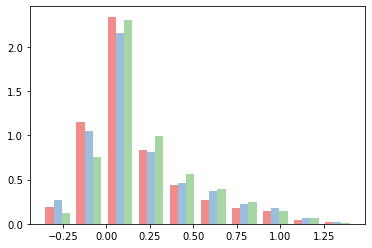

In [26]:
# grid scores in different environments
plt.hist(scores.T, density=True)

# intersection of cells active in different environments
accept_masks = independent_masks.astype(float)
accept_masks @ accept_masks.T, np.sum(np.prod(accept_masks, axis=0))

In [10]:
#no_orientation = np.any(np.isnan(grid_orientations), axis = 0) # remove NaNs
#safe = grid_orientations[:,~no_orientation]
grid_orientations = find_orientations(intersect_maps, to_array=False)
grid_orientations = [grid_orientations[i][~np.isnan(grid_orientations[i])] for i in range(len(environments))] # remove nans
# circular_grid_orientations = [grid_orientation % np.pi/3 for grid_orientation in grid_orientations]

NameError: name 'intersect_maps' is not defined

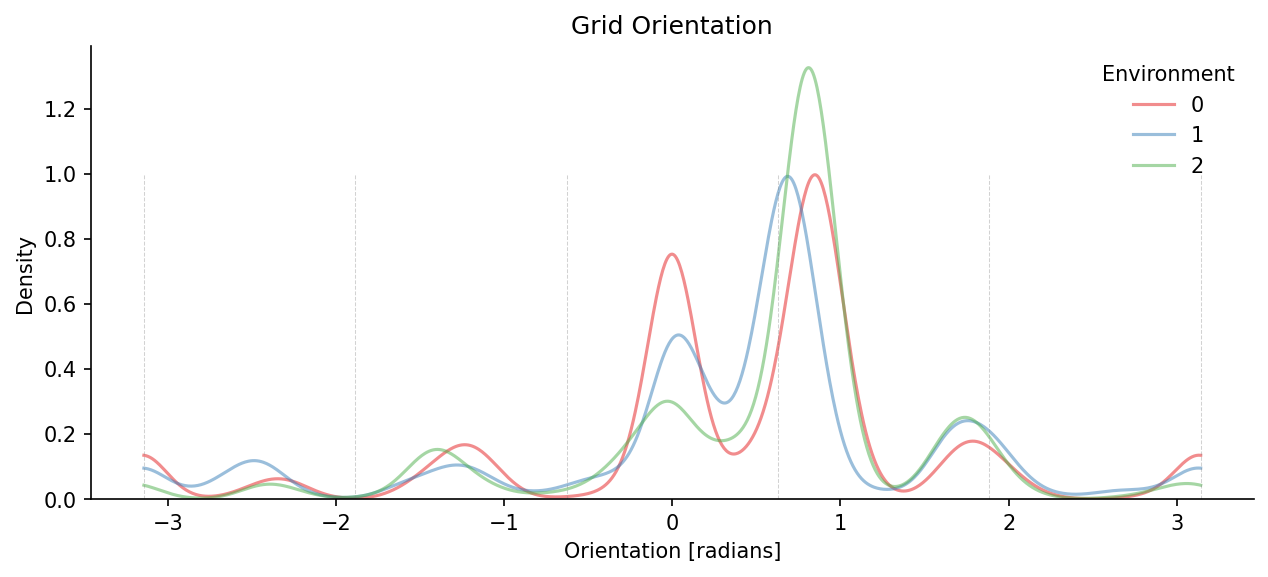

In [157]:
plot_orientations(grid_orientations, kappa = 50) # adjust kappa as needed for sharpness
plt.vlines(np.linspace(-np.pi, np.pi, 6),0,1, ls='--', color='grey', linewidth = 0.5, alpha = 0.35)

# set additional plot params
sns.despine() # maybe set these in style sheet instead?
plt.legend(title = "Environment", labels = [i for i in range(len(grid_orientations))], frameon = False)
plt.title('Grid Orientation')
plt.xlabel("Orientation [radians]")
savefig('grid-orientations')

In [158]:
grid_spacings = find_spacings(intersect_maps, to_array=False)
grid_spacings = [grid_spacings[i][~np.isnan(grid_spacings[i])] for i in range(len(environments))]
#no_spacing = np.any(np.isnan(grid_spacings), axis = 0) # remove NaNs
#safe = grid_orientations[:,~no_spacing] 

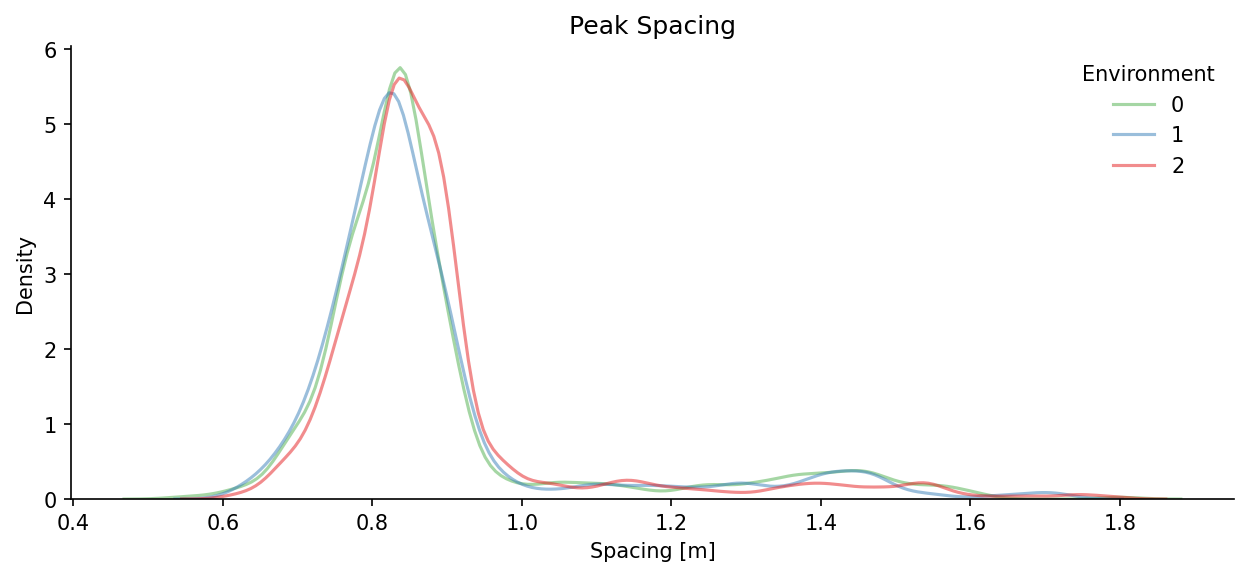

In [159]:
plot_spacings(grid_spacings, bins=50) 

sns.despine() # maybe set these in style sheet instead?
plt.legend(title = "Environment", labels = [i for i in range(len(environments))], frameon = False)
plt.title("Peak Spacing")
# hardcoded boxsize
max_spacing = np.sqrt(2*2.2**2)  # synth box diagonal
plt.xlabel("Spacing [m]")
#plt.xlim([0, max_spacing])

#loc = "./"
#plt.savefig(f"{loc}synth_orientations.svg")
savefig('peak-spacing')

In [160]:
# only calculate the upper triangular part of the matrix - since the matrix is symmetric,
# the lower triangular part is a copy of the upper triangular

grid_orientations = find_orientations(intersect_maps, to_array=True)
nan_mask = np.prod(~np.isnan(grid_orientations),axis=0).astype("bool")
grid_orientations = grid_orientations[:,nan_mask]

orientation_shifts = np.zeros((len(environments),len(environments), grid_orientations.shape[1]))
for i in range(len(environments)):
    for j in range(i, len(environments)):
        orientation_shifts[i,j] = np.mod( grid_orientations[j] - grid_orientations[i], 2*np.pi) 
upper_flat_triangle = orientation_shifts[np.triu_indices(orientation_shifts.shape[0],k=1)]


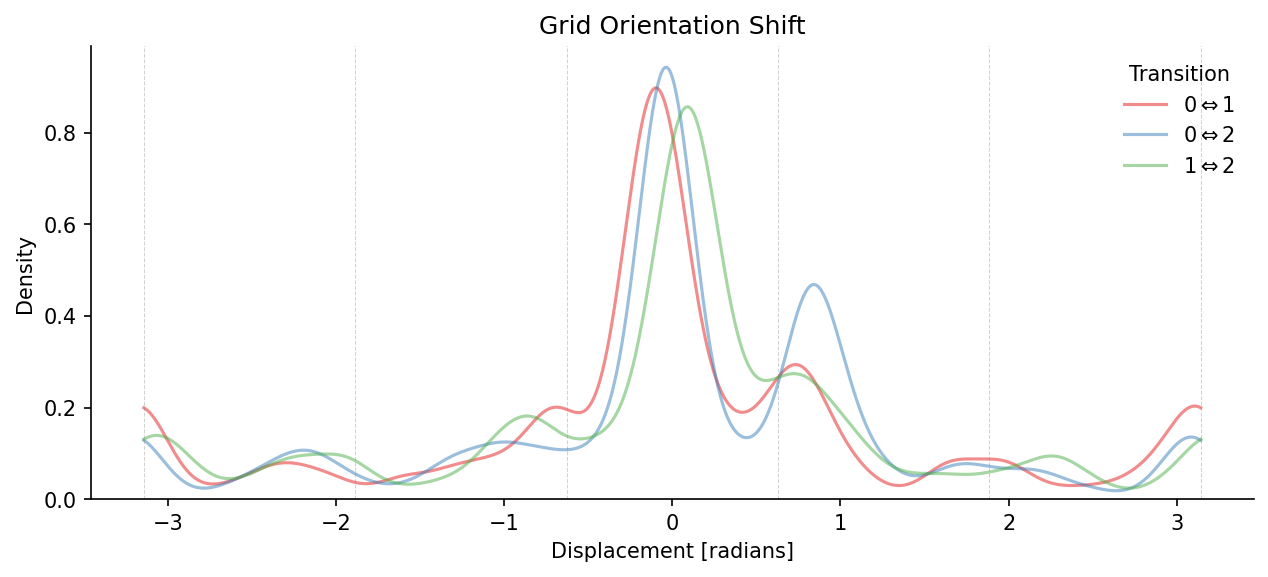

In [161]:
plot_orientations(upper_flat_triangle)
plt.vlines(np.linspace(-np.pi, np.pi, 6),0,1, ls='--', color='grey', linewidth = 0.5, alpha = 0.35)
sns.despine() # maybe set these in style sheet instead?
arrow = r"$\Leftrightarrow$"
plt.legend(title = "Transition", labels=[f'0{arrow}1',f'0{arrow}2',f'1{arrow}2'], frameon = False)
plt.title("Grid Orientation Shift")
plt.xlabel("Displacement [radians]")
savefig('orientation_shift')

In [162]:

spacings = find_spacings(intersect_maps, to_array=True)
nan_mask = np.prod(~np.isnan(spacings),axis=0).astype("bool")
spacings = spacings[:,nan_mask]

spacing_shifts = np.zeros((len(environments),len(environments), spacings.shape[1]))
for i in range(len(environments)):
    for j in range(i, len(environments)):
        spacing_shifts[i,j] = spacings[j] - spacings[i]
upper_flat_triangle = spacing_shifts[np.triu_indices(spacing_shifts.shape[0],k=1)]


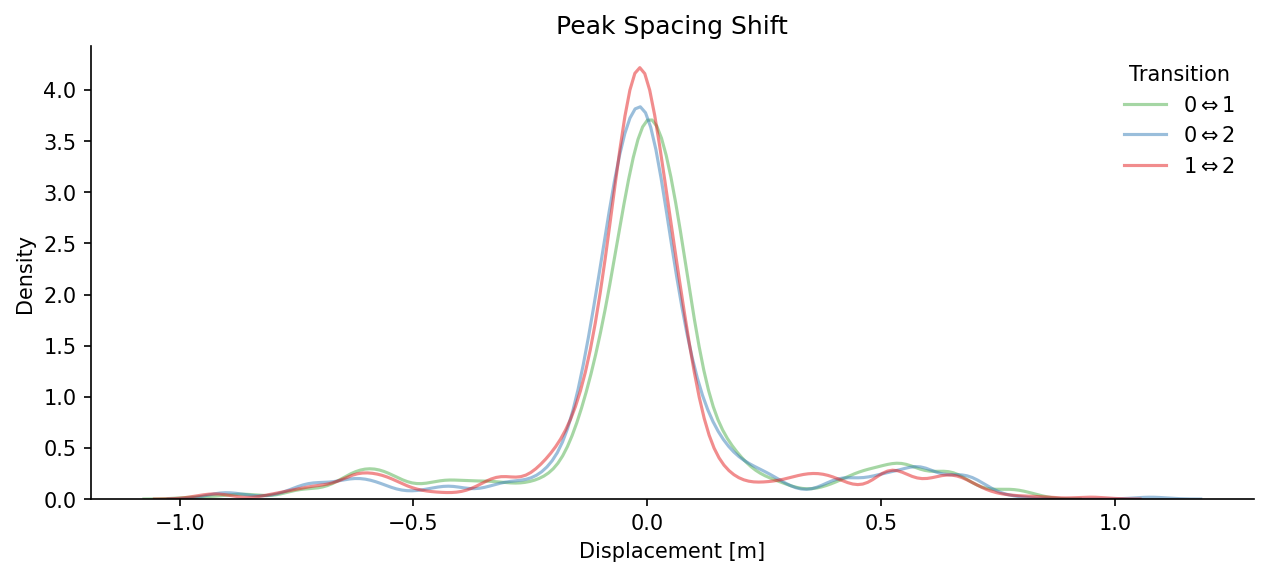

In [163]:
plot_spacings(upper_flat_triangle, bins = 50)
sns.despine() # maybe set these in style sheet instead?
arrow = r"$\Leftrightarrow$"
plt.legend(title = "Transition", labels=[f'0{arrow}1',f'0{arrow}2',f'1{arrow}2'], frameon = False)
plt.title("Peak Spacing Shift")
plt.xlabel("Displacement [m]")
savefig('spacing_shift')

In [164]:
# only calculate the upper triangular part of the matrix - since the matrix is symmetric,
# the lower triangular part is a copy of the upper triangular
shifts = np.zeros((len(environments),len(environments), intersect_maps.shape[1]))
for i in range(len(environments)):
    for j in range(i, len(environments)):
        shifts[i,j] = np.array(list(map(lambda x: phase_shift(*x), zip(intersect_maps[i],intersect_maps[j]))))
upper_flat_triangle = shifts[np.triu_indices(shifts.shape[0],k=1)]


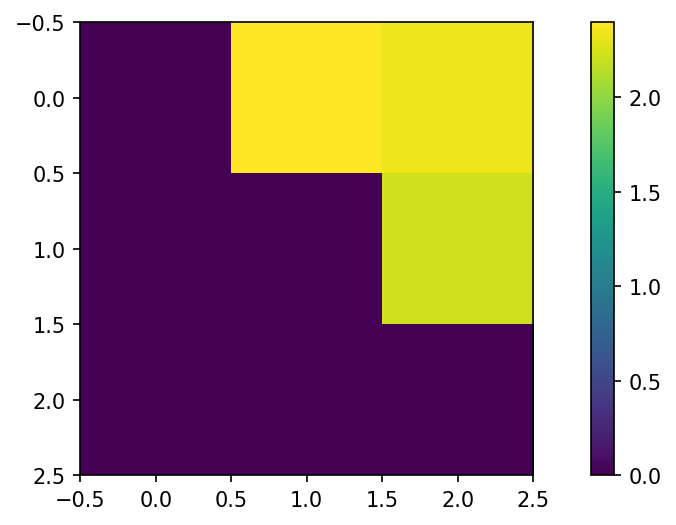

In [165]:
plt.imshow(np.nanmean(shifts,axis=-1))
plt.colorbar()

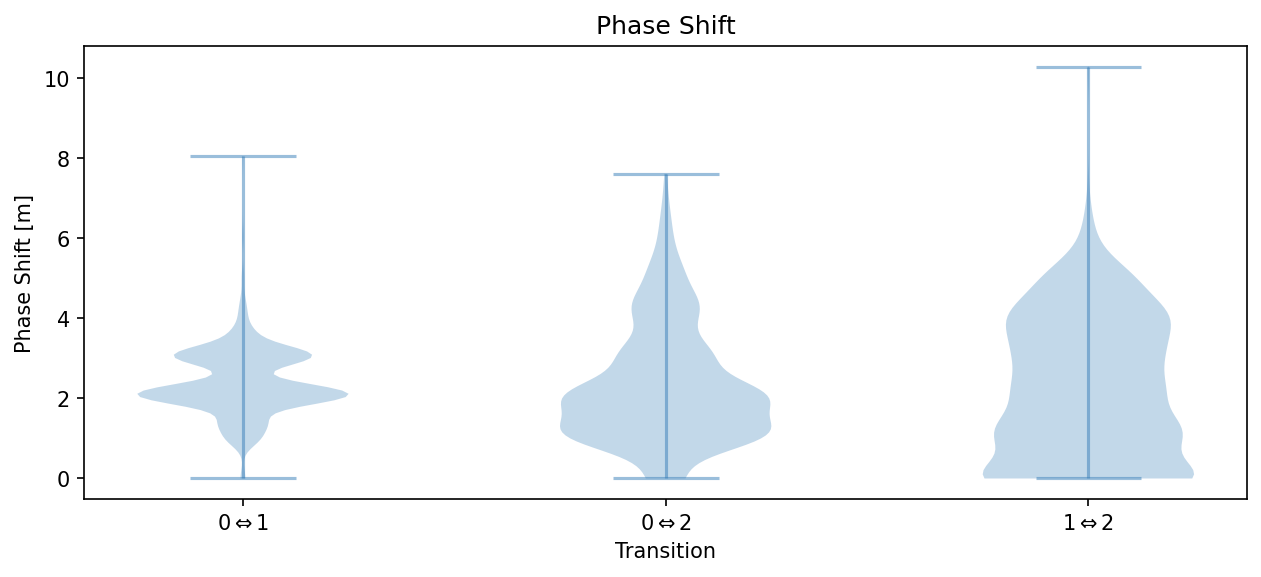

In [166]:
plt.rcParams['axes.prop_cycle'] = cycler(color=[cols[1], cols[0], cols[-1]])

if len(environments) > 2:
    data = []
    for env_phase in upper_flat_triangle:
        data.append(env_phase[~np.isnan(env_phase)])
    fig,ax = plt.subplots()
    parts = ax.violinplot(data)
    labels=[f'0{arrow}1',f'0{arrow}2',f'1{arrow}2']
    arrow = r"$\Leftrightarrow$"
    #ax.legend(title = "Transition", labels=[f'0{arrow}1',f'0{arrow}2',f'1{arrow}2'], frameon = False)
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    plt.xlabel("Transition")
    plt.ylabel("Phase Shift [m]")
    for pc in parts['bodies']:
        pc.set_facecolor(cols[1])

    plt.title("Phase Shift")
    savefig('phase-shift')

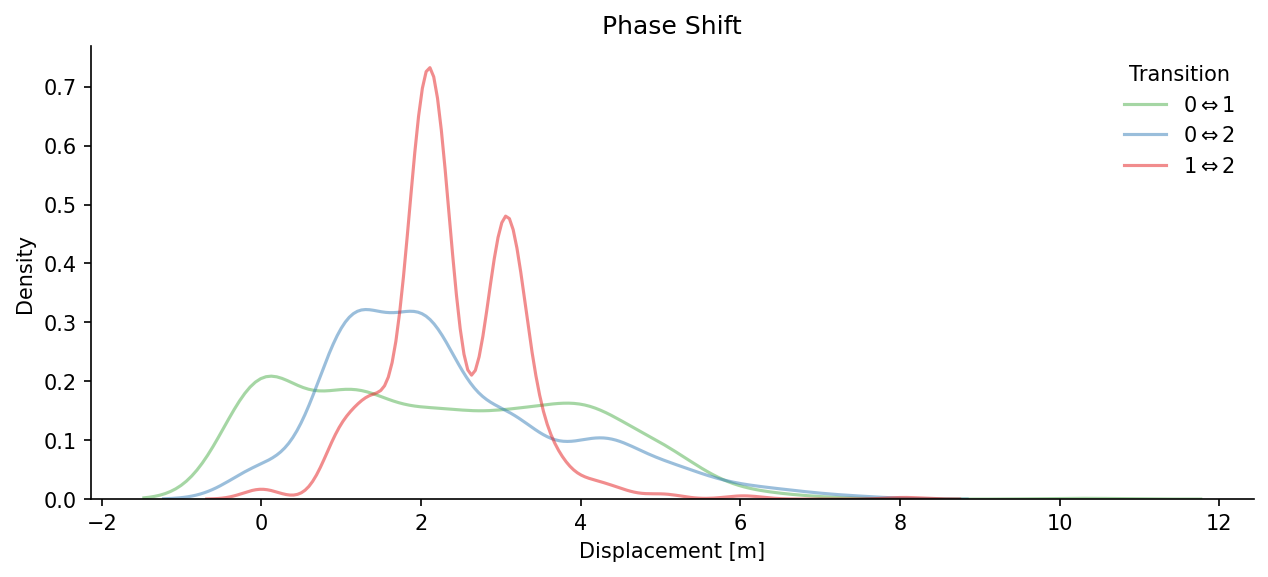

In [167]:
plot_spacings(upper_flat_triangle, bins = 50, bw_adjust = 1.0)
sns.despine() # maybe set these in style sheet instead?
arrow = r"$\Leftrightarrow$"
plt.legend(title = "Transition", labels=[f'0{arrow}1',f'0{arrow}2',f'1{arrow}2'], frameon = False)
plt.title("Phase Shift")
plt.xlabel("Displacement [m]")
savefig('phase_shift_kde')



In [168]:
# only calculate the upper triangular part of the matrix - since the matrix is symmetric,
# the lower triangular part is a copy of the upper triangular
shifts = np.zeros((len(environments),len(environments), intersect_maps.shape[1]))
for i in range(len(environments)):
    for j in range(i, len(environments)):
        shifts[i,j] = np.array(list(map(lambda x: phase_shift(*x), zip(intersect_maps[i],intersect_maps[j]))))
upper_flat_triangle = shifts[np.triu_indices(shifts.shape[0],k=1)]

## Visualize Manifold Geometry with UMAP

In [ ]:
import plotly.io as pio
pio.renderers.default = 'colab' # or 'notebook' or 'iframe' or 'jupyterlab'

In [ ]:
def plot_3d_proj(data, tags):
    fig = go.Figure(data=[go.Scatter3d(
        x=data[:,0],
        y=data[:,1],
        z=data[:,2],
        mode='markers',
        marker=dict(
            size=1,
            color=tags,                # set color to an array/list of desired values
            colorscale='Hsv',   # choose a colorscale
            opacity=0.8
        )
    )])
    # tight layout
    fig.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=False )
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
    fig.show()

In [ ]:
num_workers = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"{device=}")

num_samples = params['nsteps'] * params['batch_size']*4 # * params['nepochs']
dataset = Dataset(agents = agents, pc_ensembles = pc_ensembles, num_samples = num_samples, **params)
datasampler = eval(params['sampler'])(num_environments = len(environments), num_samples = num_samples, \
                                      num_epochs = params['nepochs'])
dataloader = torch.utils.data.DataLoader(dataset, batch_size=params['batch_size'], sampler = datasampler, num_workers=num_workers)

In [ ]:
# Initialise model
model = SorscherRNN(pc_ensembles, Ng=params['Ng'], Np=params['Np'])
model.to(device)
print(f"{model = }")

for env_i in range(len(environments)):
    checkpoint_filenames = filenames(paths['checkpoints'])
    checkpoint = torch.load(paths['checkpoints'] / checkpoint_filenames[-1])
    model.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
def rotation_matrix(theta):
    a = np.cos(theta)
    b = np.sin(theta)
    return np.stack(([a, -b], [b, a]), axis = 0)
    
gc_activity = []
for i,(inputs,_,_,_) in enumerate(dataloader):
    print(i)
    #inputs[0] = inputs[0]@rotation_matrix(np.pi/6)
    gc_activity.append(model.g(inputs).detach().cpu().numpy())#[...,intersect_masks])
    if i == 10:
        break

gc_activity = np.array(gc_activity).reshape(-1,params["Ng"])#np.sum(intersect_masks))
gc_activity.shape

In [ ]:
# Standard UMAP
fit = umap.UMAP(n_components = 3)
u = fit.fit_transform(gc_activity)
plot_3d_proj(u, np.ones(len(gc_activity)))


In [ ]:
# sort by grid score
large_score = scores[2] > 1
print(np.sum(large_score))

fit = umap.UMAP(n_components = 3)
u = fit.fit_transform(gc_activity[:,large_score])
plot_3d_proj(u, np.ones(len(gc_activity)))

In [ ]:
# sort by spacing
spacings = find_spacings(ratemaps, to_array=False)
small_spacing = spacings[2] < 1.0


print(np.sum(small_spacing))
print(small_spacing.shape)
fit = umap.UMAP(n_components = 3)
u = fit.fit_transform(gc_activity[:,small_spacing])
plot_3d_proj(u, np.ones(len(gc_activity)))

In [ ]:
# sort by orientation
orientations =  find_orientations(ratemaps, to_array=False)

small_or = (orientations[2] < 1)*(orientations[2] > 0.5)


print(np.sum(small_or))
print(small_or.shape)
fit = umap.UMAP(n_components = 3)
u = fit.fit_transform(gc_activity[:,small_or])
plot_3d_proj(u, np.ones(len(u)))

In [ ]:


def ratemap_trajectories(dataset, environment_idx, num_trajectories=1500):
    """Generate trajectories to compute ratemaps with (scipy.stats.binned_statistics_2d)"""
    batch_velocities, batch_init_pc_positions, batch_positions = [], [], []
    for _ in range(num_trajectories):
        (velocities, init_pc_positions), _, positions, _ = dataset[environment_idx]
        batch_velocities.append(velocities)
        batch_init_pc_positions.append(init_pc_positions)
        batch_positions.append(positions)
    batch_inputs = [torch.stack(batch_velocities), torch.stack(batch_init_pc_positions)]
    batch_positions = torch.stack(batch_positions).detach().numpy()
    x = np.ravel(batch_positions[:,1:,0])
    y = np.ravel(batch_positions[:,1:,1])
    return batch_inputs, x, y



In [ ]:
dataset = Dataset(agents = agents, pc_ensembles = pc_ensembles, num_samples = 5000, **params)
batch_inputs, x, y = ratemap_trajectories(dataset, 2)
activities = model.g(batch_inputs).detach().cpu().numpy()
print(activities.shape)
activities = activities.reshape(-1, activities.shape[-1])


In [ ]:
fit = umap.UMAP(n_components = 3)
super_mask = small_or*small_spacing
print(np.sum(super_mask))
u = fit.fit_transform(activities[:,super_mask])
plot_3d_proj(u, np.ones(len(u)))